# Обработка лабы 5.5

In [1]:
# Импротируем необходимые функции
import numpy as np # работа с массивами и линейной алгеброй
import matplotlib.pyplot as plt # для отрисовки графиков
import pandas as pd # для чтения и работы с данными
from scipy.optimize import curve_fit # фитирующая процедура

In [2]:
# Функция, которая приводит данные к нужному виду
def read_file(path):
    df = pd.read_excel(path)
    df = df.drop(df.index[[0,1,2,3,4]])
    df.columns = ['Channel', 'Counts']
    df.index = np.arange(0, len(df))
    df['Counts'] = df['Counts'].apply(np.float64)
    df['Channel'] = df['Channel'].apply(np.float64)
    df['Error'] = df['Counts']
    df['Error'] = df['Error'].apply(np.sqrt)
    return df

In [81]:
# Функция, которая рисует датасет
def draw(df, title, err = False):
    x = df["Channel"]
    y = df["Counts"]
    plt.figure(figsize=(15,7))
    if(err):
        plt.errorbar(x, y, yerr=df['Error'], color = "green", label = "Кресты погрешности".decode('utf-8'))
        plt.scatter(x, y, label='Данные'.decode('utf-8'))
    else:
        plt.plot(x, y, label='Данные'.decode('utf-8'))
    plt.title(title)
    plt.xlabel('Номер канала'.decode('utf-8'))
    plt.ylabel('Счет'.decode('utf-8'))
    plt.legend()
    plt.grid() # Активирует сетку
    
def draw1(df, title, err = False):
    x = (df["Channel"] - 40.8)/1222
    y = df["Counts"]
    plt.figure(figsize=(15,7))
    if(err):
        plt.errorbar(x, y, yerr=df['Error'], color = "green", label = "Кресты погрешности".decode('utf-8'))
        plt.scatter(x, y, label='Данные'.decode('utf-8'))
    else:
        plt.plot(x, y, label='Данные'.decode('utf-8'))
    plt.title(title)
    plt.xlabel('E, МэВ'.decode('utf-8'))
    plt.ylabel('Счет'.decode('utf-8'))
    plt.legend()
    plt.grid() # Активирует сетку

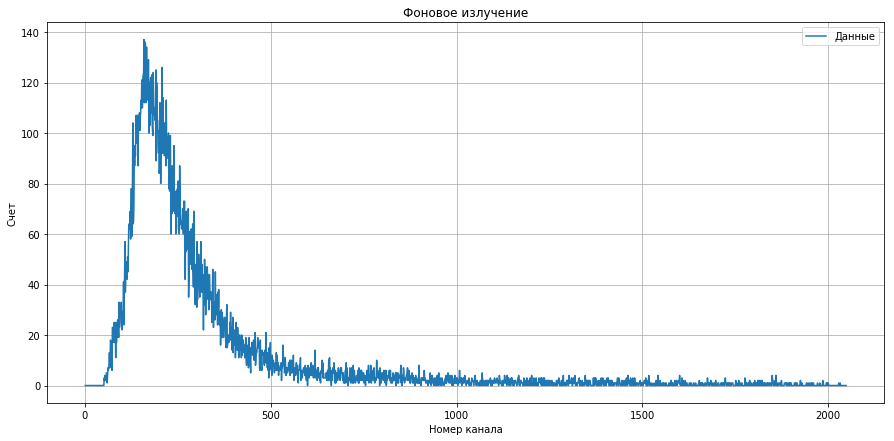

In [4]:
# Импорт данных (поработаем пока с фоном)
data_b = read_file('data/excel/background.xlsx')
draw(data_b, 'Фоновое излучение'.decode('utf-8'))
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

Будем фитировать фоновое излучение экспонентой вида
$a\cdot e^{-b(x-x_0)}$, начиная с того момента, как фон падает.

In [5]:
# Функция экспоненты (делим x на тысячу, чтобы фитирование не баговало)
def exp(x, a, b, x0):
    return a*np.exp(-b*(x/1000.0-x0))

In [6]:
delta_1 = 160
delta_2 = len(data_b)
data_b_exp = data_b.iloc[delta_1:delta_2]

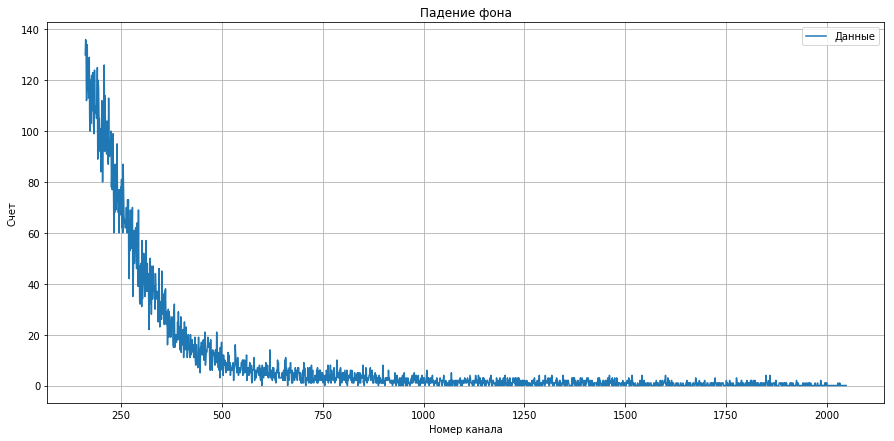

In [7]:
draw(data_b_exp, 'Падение фона'.decode('utf-8'))
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

In [8]:
popt_b, pcov_b = curve_fit(f = exp, xdata= data_b_exp['Channel'], ydata=data_b_exp['Counts'], maxfev=10000)
popt_b

array([ 0.16612494,  7.55330569,  1.04704429])

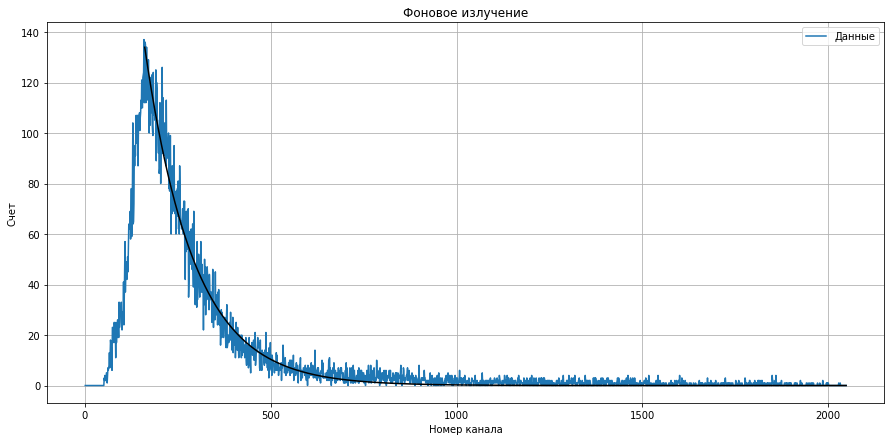

In [9]:
draw(data_b, 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_b_exp['Channel'], exp(data_b_exp['Channel'], *popt_b), color = 'black')
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

Таким образом искомая функция, фитирующая фон есть
$$
y = 0.166\cdot e^{-7.553\cdot 10^{-3}(x-1047)}.
$$

Теперь посмотрим на спектр $Co_{60}$.

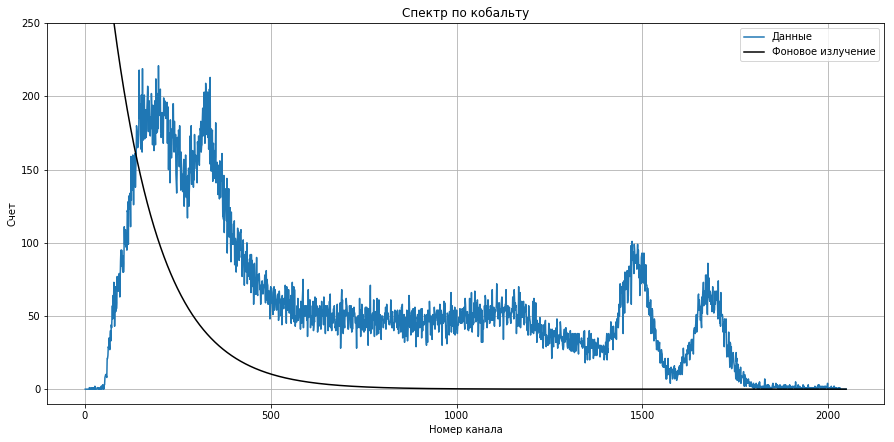

In [10]:
data_co = read_file('data/excel/Co60.xlsx')
draw(data_co, 'Спектр по кобальту'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.ylim(-10,250)
#plt.xlim(-10,250)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

Отчетливо видны два фотопика, пик обратного рассеивания и пик характеристического излучения.

Для начала найдем значения каналов для фотопиков. Для этого фитируем их под функцию нормального распределения.

In [11]:
# Функция нормального распределения
def gauss_function_c(x, a, x0, s, c):
    return a*np.exp(-(x/1000.0-x0)**2/(2*s**2)) + c

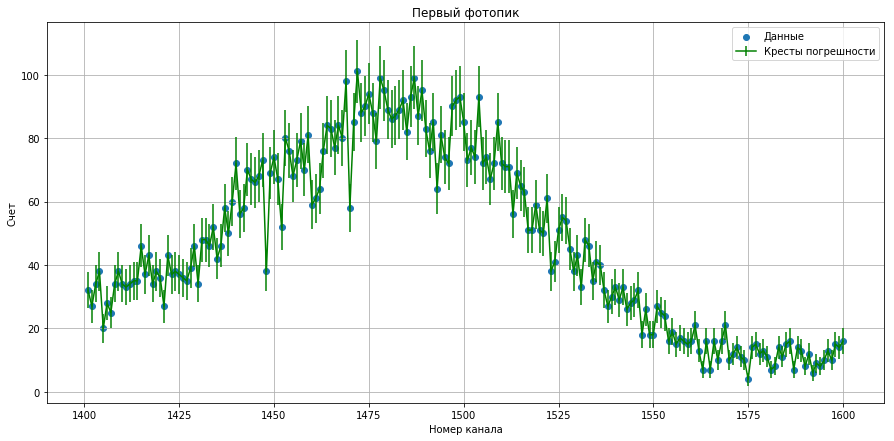

In [12]:
# Выделим первый пик
delta_1 = 1400
delta_2 = 1600

data_co_f = data_co.iloc[delta_1:delta_2]
draw(data_co_f, 'Первый фотопик'.decode('utf-8'), True)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

In [13]:
popt_co_f, pcov_co_f = curve_fit(f = gauss_function_c, 
                                 xdata= data_co_f['Channel'], 
                                 ydata=data_co_f['Counts'], maxfev=10000, sigma = data_co_f['Error'])
popt_co_f

array([  7.85234886e+01,   1.47789389e+00,  -3.97644235e-02,
         7.71111590e+00])

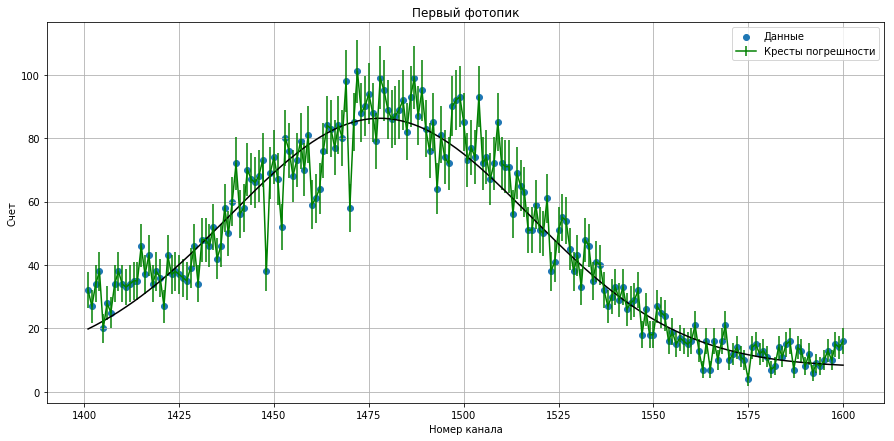

In [14]:
draw(data_co_f, 'Первый фотопик'.decode('utf-8'), True)
plt.plot(data_co_f['Channel'], gauss_function_c(data_co_f['Channel'], *popt_co_f), color = 'black')
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

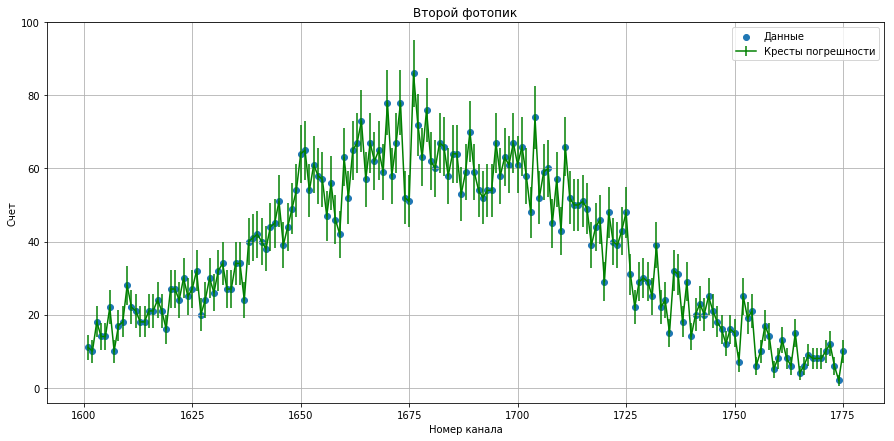

In [15]:
# Выделим второй пик
delta_1 = 1600
delta_2 = 1775

data_co_sec = data_co.iloc[delta_1:delta_2]
draw(data_co_sec, 'Второй фотопик'.decode('utf-8'), True)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

In [16]:
popt_co_sec, pcov_co_sec = curve_fit(f = gauss_function_c, 
                                 xdata= data_co_sec['Channel'], 
                                 ydata=data_co_sec['Counts'], maxfev=10000, sigma = data_co_sec['Error'])
popt_co_sec

array([  6.34947291e+01,   1.67920941e+00,  -3.95536755e-02,
         1.58252518e+00])

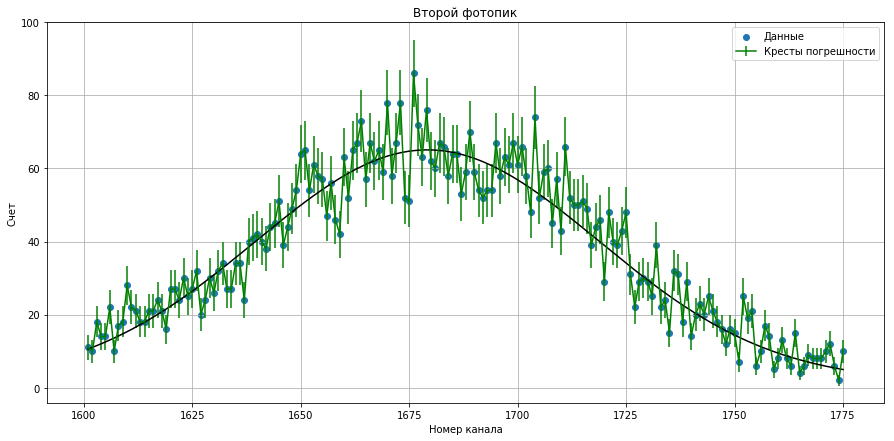

In [17]:
draw(data_co_sec, 'Второй фотопик'.decode('utf-8'), True)
plt.plot(data_co_sec['Channel'], gauss_function_c(data_co_sec['Channel'], *popt_co_sec), color = 'black')
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

Что же получилось в итоге?

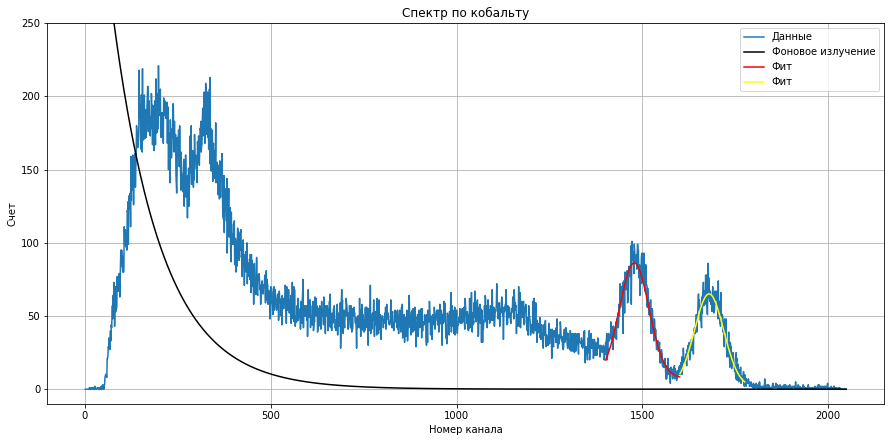

In [18]:
data_co = read_file('data/excel/Co60.xlsx')
draw(data_co, 'Спектр по кобальту'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_co_f['Channel'], gauss_function_c(data_co_f['Channel'], *popt_co_f), color = 'red', label='Фит'.decode('utf-8'))
plt.plot(data_co_sec['Channel'], gauss_function_c(data_co_sec['Channel'], *popt_co_sec), color = 'yellow', label='Фит'.decode('utf-8'))
plt.legend()
plt.ylim(-10,250)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

### Пики полного полгощения Na и Cs
#### Пик Na

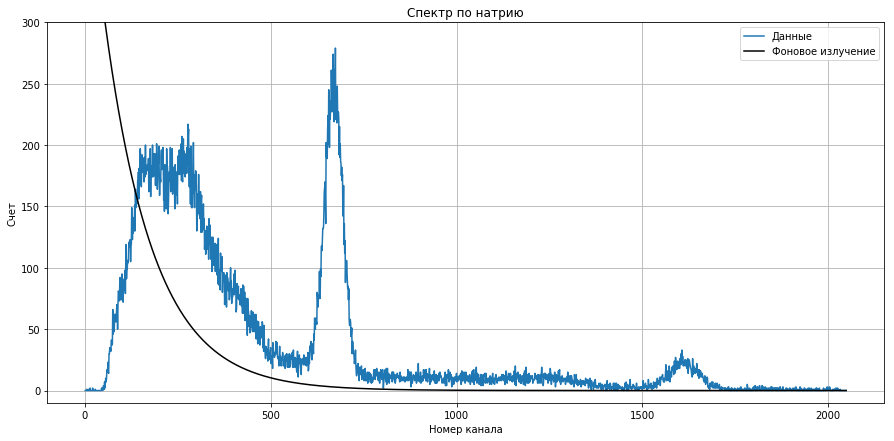

In [19]:
data_na = read_file('data/excel/Na22.xlsx')
draw(data_na, 'Спектр по натрию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.ylim(-10,300)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

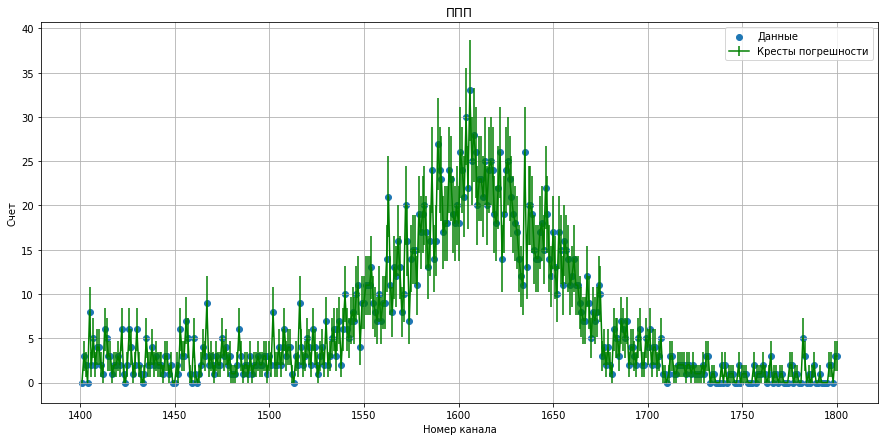

In [20]:
delta_1 = 1400
delta_2 = 1800

data_na_pp = data_na.iloc[delta_1:delta_2]
draw(data_na_pp, 'ППП'.decode('utf-8'), True)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

In [21]:
popt_na_pp, pcov_na_pp = curve_fit(f = gauss_function_c, 
                                 xdata= data_na_pp['Channel'], 
                                 ydata=data_na_pp['Counts'], maxfev=10000)
popt_na_pp

array([ 20.86331376,   1.61016447,   0.03836755,   1.8637734 ])

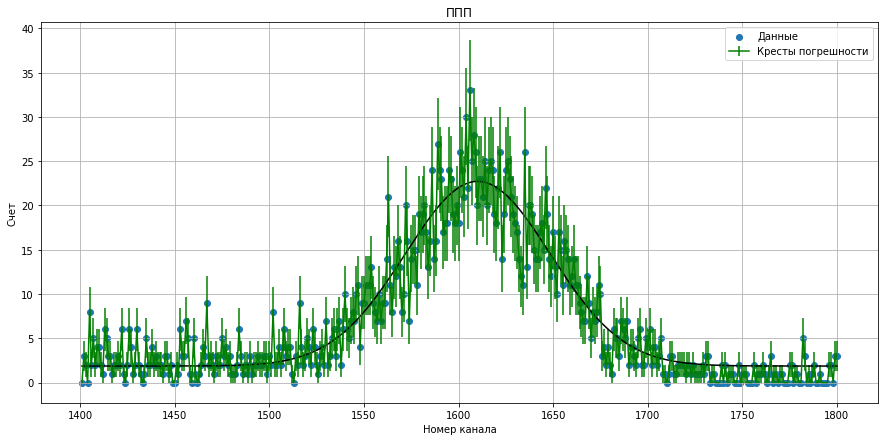

In [22]:
draw(data_na_pp, 'ППП'.decode('utf-8'), True)
plt.plot(data_na_pp['Channel'], gauss_function_c(data_na_pp['Channel'], *popt_na_pp), color = 'black')
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

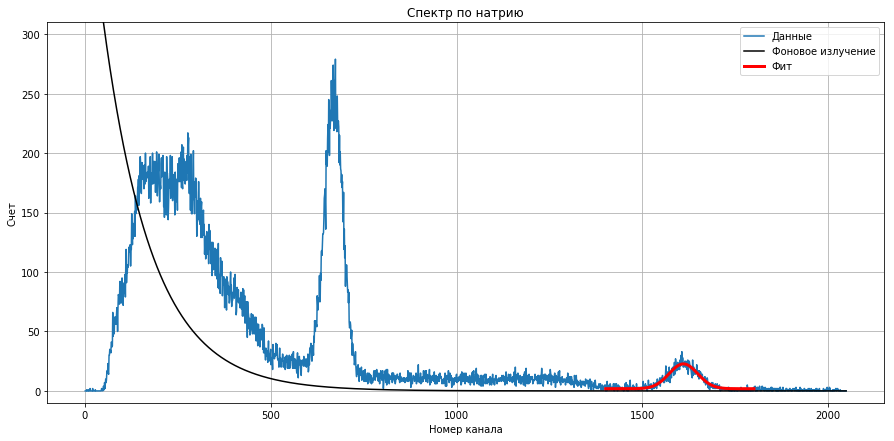

In [23]:
draw(data_na, 'Спектр по натрию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_na_pp['Channel'], gauss_function_c(data_na_pp['Channel'], *popt_na_pp), color = 'red', linewidth = 3, label='Фит'.decode('utf-8'))
plt.legend()
plt.ylim(-10,310)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

Каналу ППП натрия $(160\pm4)\cdot 10$ соответсвтует энергия $E_{\text{ППП}} = 1.275 \text{ МэВ}$.

#### Пик Cs

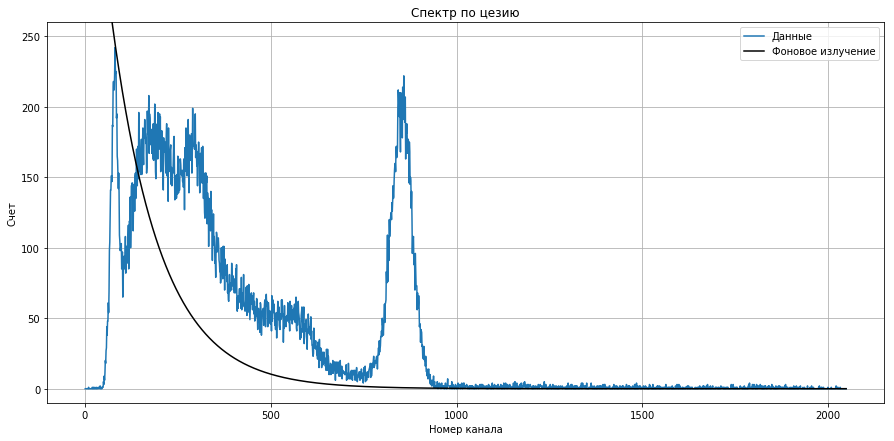

In [53]:
data_cs = read_file('data/excel/Cs137.xlsx')
draw(data_cs, 'Спектр по цезию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.ylim(-10,260)
plt.show()

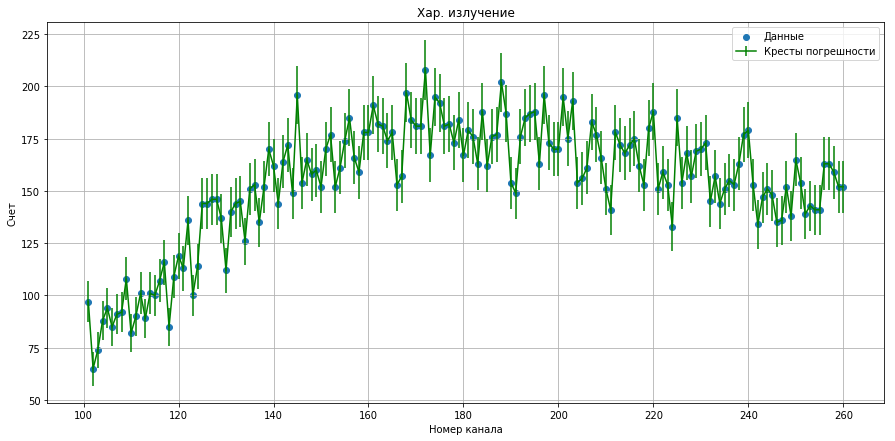

In [25]:
delta_1 = 100
delta_2 = 260

data_cs_har = data_cs.iloc[delta_1:delta_2]
draw(data_cs_har, 'Хар. излучение'.decode('utf-8'), True)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

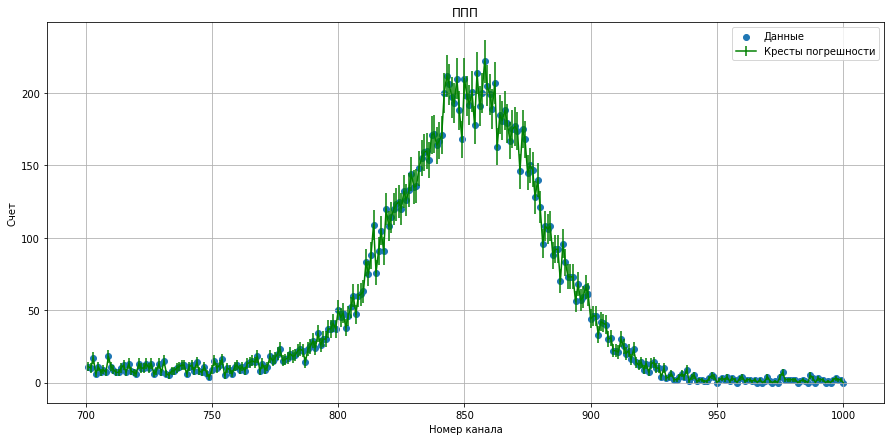

In [26]:
delta_1 = 700
delta_2 = 1000

data_cs_pp = data_cs.iloc[delta_1:delta_2]
draw(data_cs_pp, 'ППП'.decode('utf-8'), True)
plt.show()

In [27]:
# Функция нормального распределения
#def gauss_function_c(x, a, x0, s, c):
#    return a*np.exp(-(x/3000.0-x0)**2/(2*s**2)) + c
popt_cs_pp, pcov_cs_pp = curve_fit(f = gauss_function_c, 
                                 xdata= data_cs_pp['Channel'], 
                                 ydata=data_cs_pp['Counts'], maxfev=10000)
popt_cs_pp

array([  1.94029950e+02,   8.52151167e-01,  -2.78545239e-02,
         6.11882698e+00])

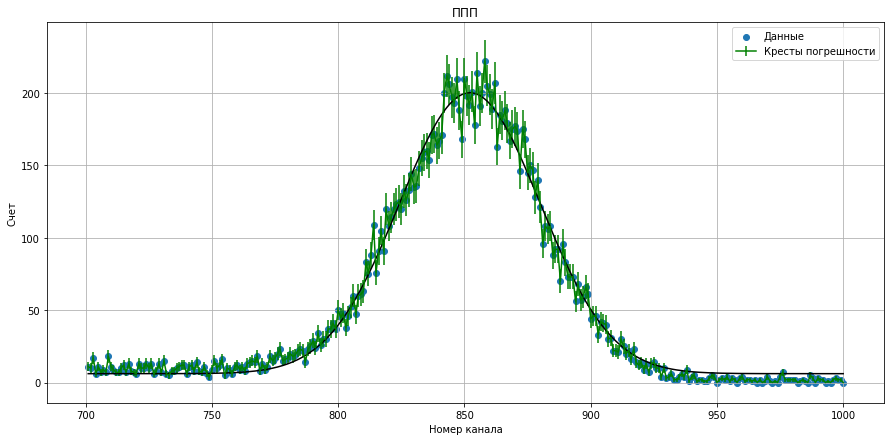

In [28]:
draw(data_cs_pp, 'ППП'.decode('utf-8'), True)
plt.plot(data_cs_pp['Channel'], gauss_function_c(data_cs_pp['Channel'], *popt_cs_pp), color = 'black')
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

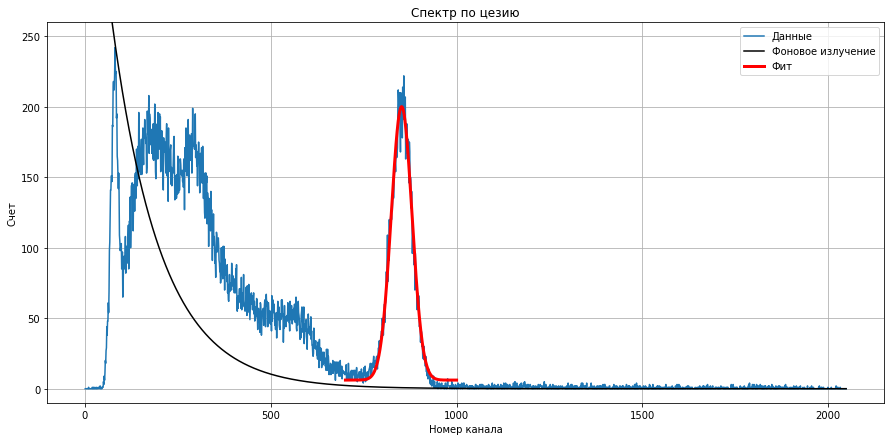

In [29]:
draw(data_cs, 'Спектр по цезию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_cs_pp['Channel'], gauss_function_c(data_cs_pp['Channel'], *popt_cs_pp), color = 'red', linewidth = 3, label='Фит'.decode('utf-8'))
plt.legend()
plt.ylim(-10,260)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

Каналу ППП цезия $(85\pm3)\cdot 10$ соответсвтует энергия $E_{\text{ППП}} = 0.6617 \text{ МэВ}$.

#### Спектр Cs с другой установки

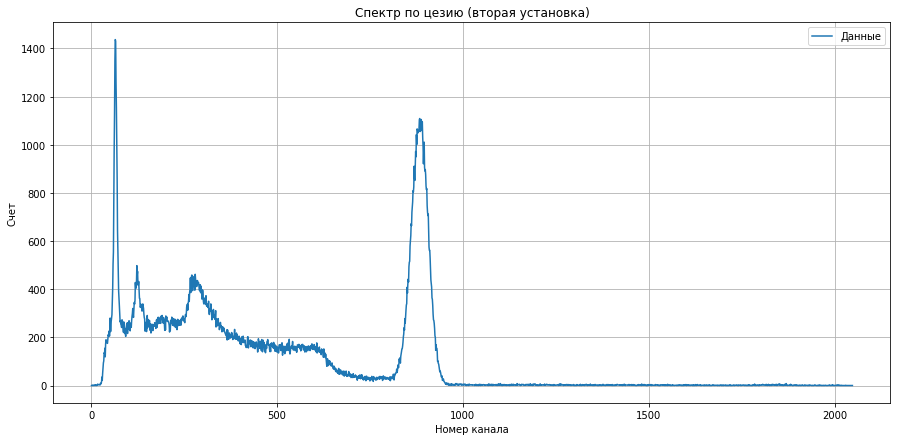

In [59]:
data_cs2 = read_file('data/excel/Cs137_D.xlsx')
draw(data_cs2, 'Спектр по цезию (вторая установка)'.decode('utf-8'))
#plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
#plt.ylim(-10,260)
plt.show()

### Спектр Америция

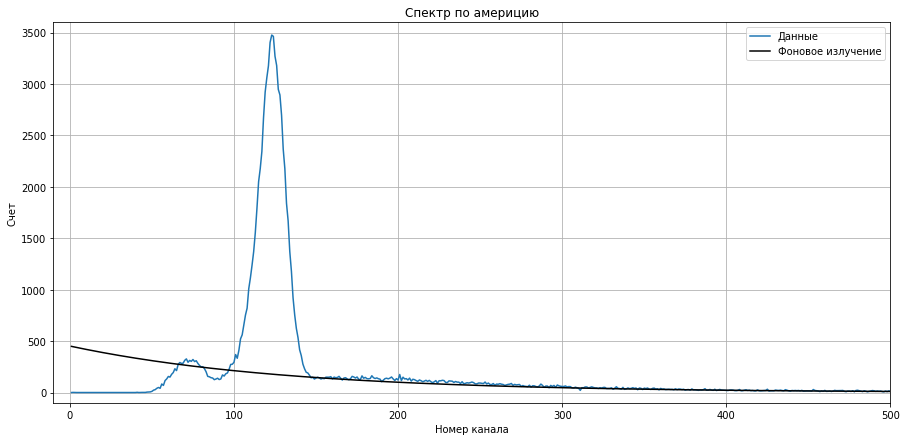

In [30]:
data_am = read_file('data/excel/Am241.xlsx')
draw(data_am, 'Спектр по америцию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.ylim(-100,3600)
plt.xlim(-10, 500)
plt.xlabel('Номер канала'.decode('utf-8'))
plt.ylabel('Счет'.decode('utf-8'))
plt.show()

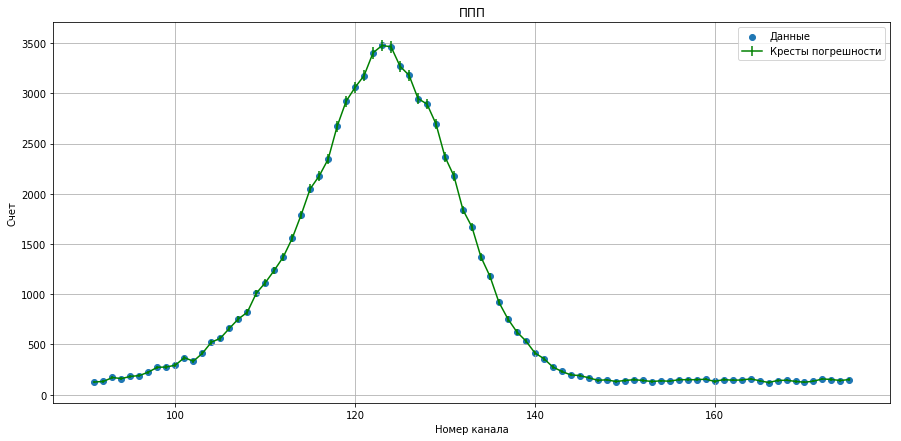

In [31]:
delta_1 = 90
delta_2 = 175

data_am_pp = data_am.iloc[delta_1:delta_2]
draw(data_am_pp, 'ППП'.decode('utf-8'), True)
plt.show()

In [32]:
popt_am_pp, pcov_am_pp = curve_fit(f = gauss_function_c, xdata= data_am_pp['Channel'],ydata=data_am_pp['Counts'], maxfev=10000)
popt_am_pp

array([  3.19108295e+03,   1.23057797e-01,   8.01662793e-03,
         1.59184385e+02])

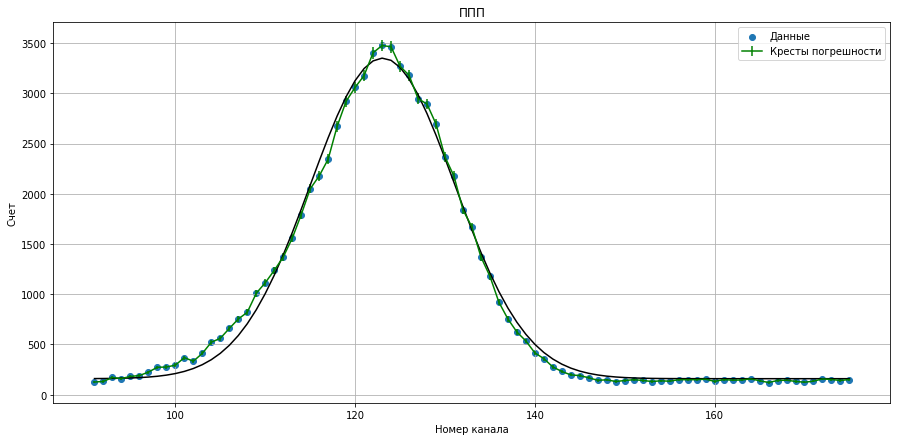

In [33]:
draw(data_am_pp, 'ППП'.decode('utf-8'), True)
plt.plot(data_am_pp['Channel'], gauss_function_c(data_am_pp['Channel'], *popt_am_pp), color = 'black')
plt.show()

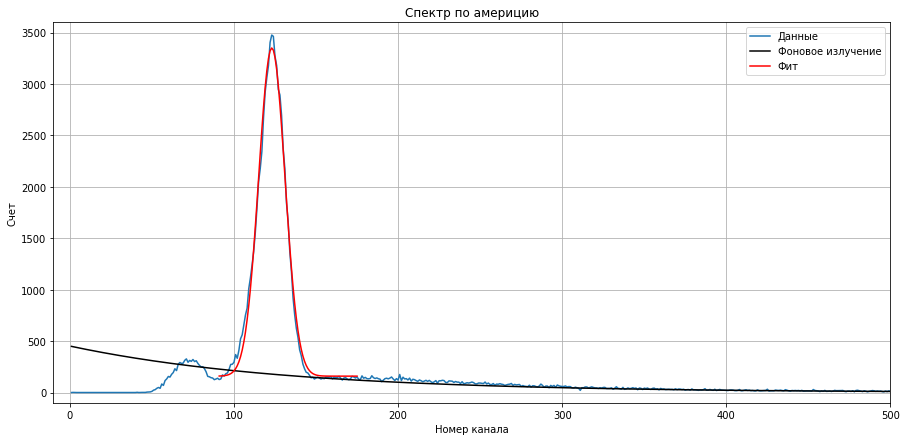

In [34]:
data_cs = read_file('data/excel/Am241.xlsx')
draw(data_am, 'Спектр по америцию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_am_pp['Channel'], gauss_function_c(data_am_pp['Channel'], *popt_am_pp), color = 'red', label = 'Фит'.decode('utf-8'))
plt.legend()
plt.ylim(-100,3600)
plt.xlim(-10, 500)
plt.show()

### Спектр Европия

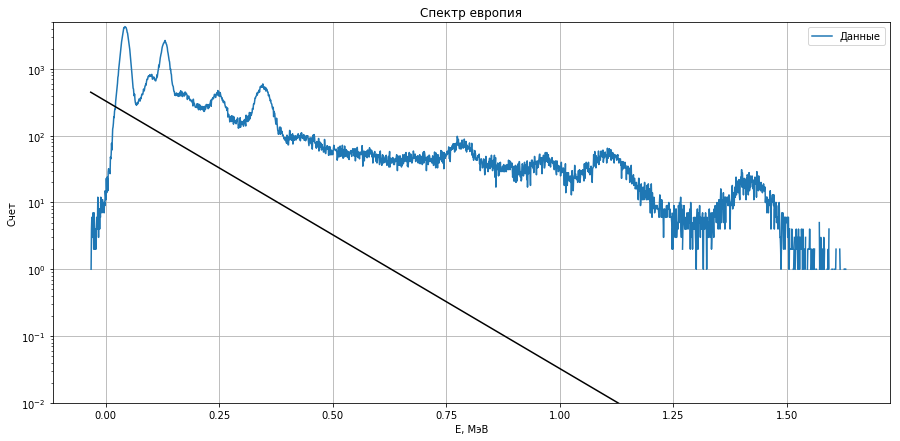

In [82]:
data_eu = read_file('data/excel/Eu152.xlsx')
'''plt.figure(figsize=(15,7))
plt.plot(data_eu['Channel'], data_eu["Counts"])
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.grid()'''
draw1(data_eu, 'Спектр европия'.decode('utf-8'), False)
plt.plot((data_b['Channel'] - 40.8)/1222, exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.ylim(0.01, 5000)
#plt.xlim(1, 2000)
plt.yscale('log')
plt.show()

Возьмем логарифм от значений

In [36]:
data_eu_l = data_eu.copy()
data_eu_l['Counts'] = data_eu_l[data_eu_l['Counts'] != 0.0]['Counts'].apply(np.log)
data_eu_l = data_eu_l.dropna()

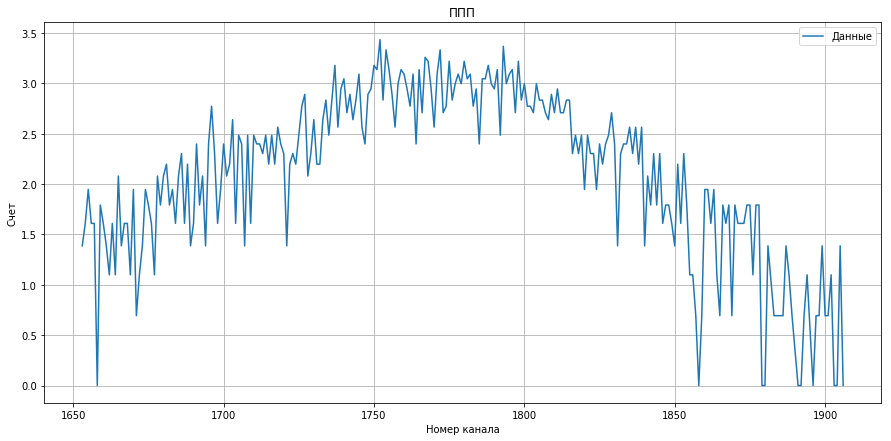

In [37]:
delta_1 = 1650
delta_2 = 1900

data_eu_l1 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l1, 'ППП'.decode('utf-8'), False)
plt.show()

In [38]:
popt_eu_l1, pcov_eu_l1 = curve_fit(f = gauss_function_c, xdata= data_eu_l1['Channel'],ydata=data_eu_l1['Counts'], maxfev=10000)
popt_eu_l1

array([ 3.66831331,  1.76692738,  0.09409578, -0.69421053])

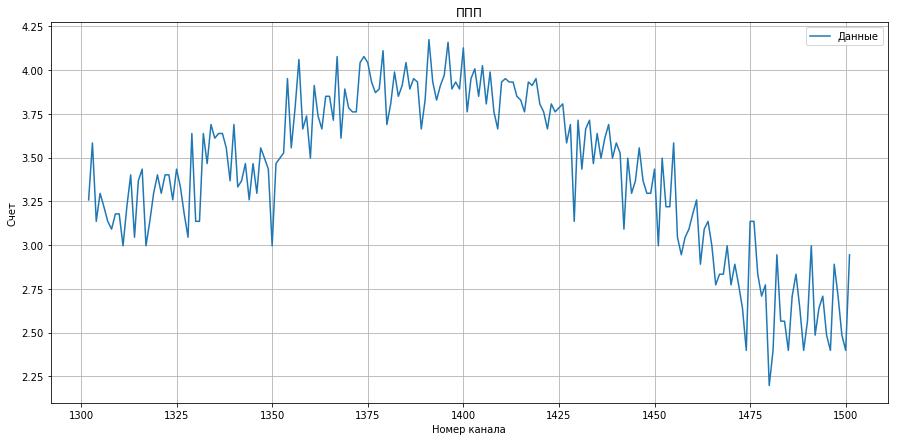

In [39]:
delta_1 = 1300
delta_2 = 1500

data_eu_l2 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l2, 'ППП'.decode('utf-8'), False)
plt.show()

In [40]:
popt_eu_l2, pcov_eu_l2 = curve_fit(f = gauss_function_c, xdata= data_eu_l2['Channel'],ydata=data_eu_l2['Counts'], maxfev=10000)
popt_eu_l2

array([ 1.92650378,  1.38596113, -0.07081249,  1.9978362 ])

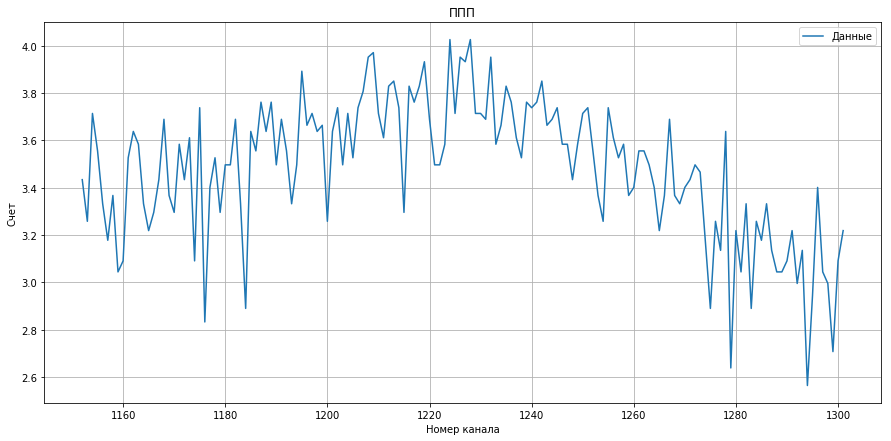

In [41]:
delta_1 = 1150
delta_2 = 1300

data_eu_l3 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l3, 'ППП'.decode('utf-8'), False)
plt.show()

In [42]:
popt_eu_l3, pcov_eu_l3 = curve_fit(f = gauss_function_c, xdata= data_eu_l3['Channel'],ydata=data_eu_l3['Counts'], maxfev=10000)
popt_eu_l3

array([ 1.10527601,  1.2172912 , -0.05620572,  2.63758715])

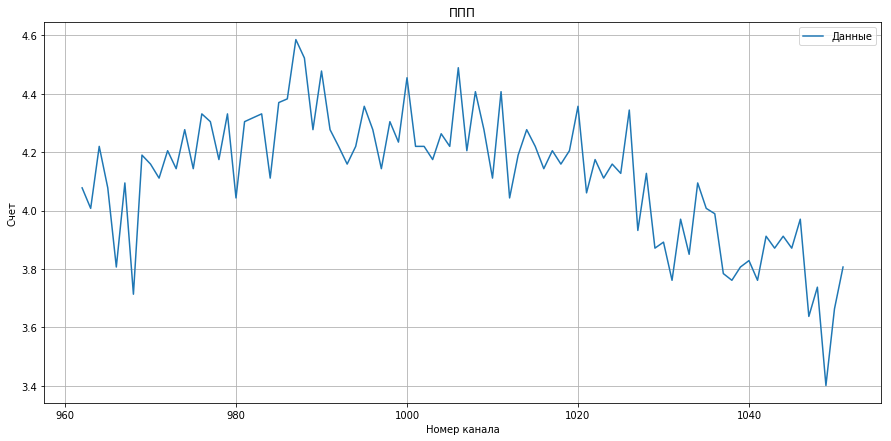

In [43]:
delta_1 = 960
delta_2 = 1050

data_eu_l4 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l4, 'ППП'.decode('utf-8'), False)
plt.show()

In [44]:
popt_eu_l4, pcov_eu_l4 = curve_fit(f = gauss_function_c, xdata= data_eu_l4['Channel'],ydata=data_eu_l4['Counts'], maxfev=10000)
popt_eu_l4

array([-0.51192852,  1.05078881, -0.01562558,  4.23441117])

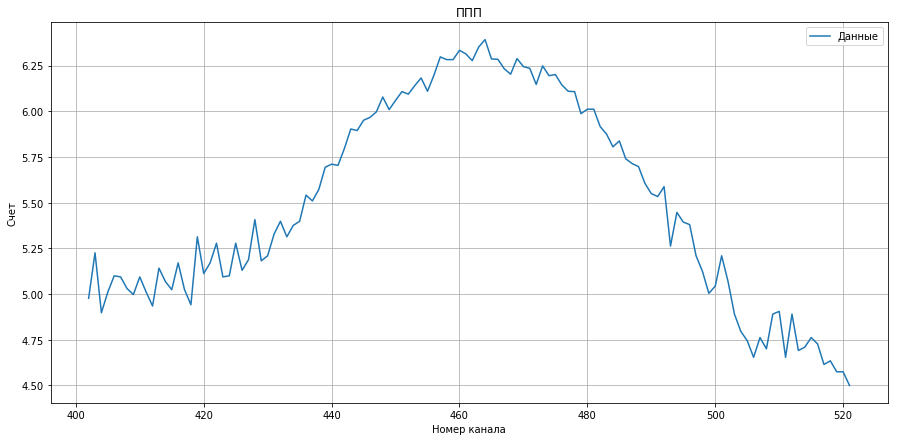

In [45]:
delta_1 = 400
delta_2 = 520

data_eu_l5 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l5, 'ППП'.decode('utf-8'), False)
plt.show()

In [46]:
popt_eu_l5, pcov_eu_l5 = curve_fit(f = gauss_function_c, xdata= data_eu_l5['Channel'],ydata=data_eu_l5['Counts'], maxfev=10000)
popt_eu_l5

array([ 1.57396215,  0.4623392 ,  0.02259982,  4.75759039])

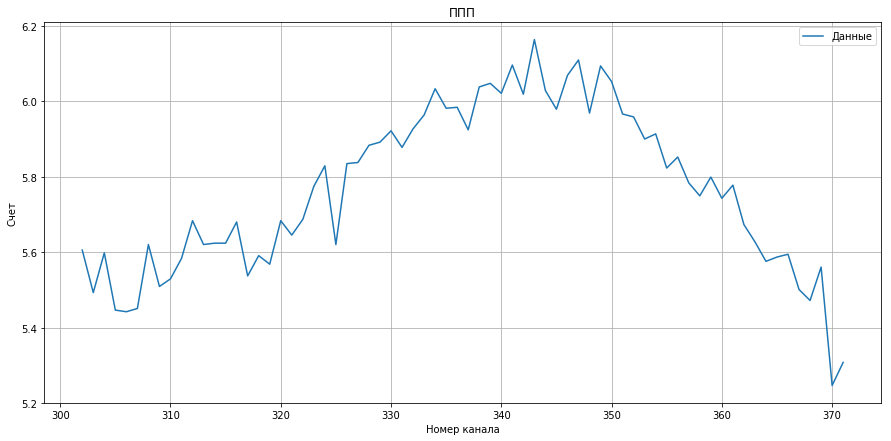

In [47]:
delta_1 = 300
delta_2 = 370

data_eu_l6 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l6, 'ППП'.decode('utf-8'), False)
plt.show()

In [48]:
popt_eu_l6, pcov_eu_l6 = curve_fit(f = gauss_function_c, xdata= data_eu_l6['Channel'],ydata=data_eu_l6['Counts'], maxfev=10000)
popt_eu_l6

array([ 0.5997501 ,  0.34138105, -0.01381991,  5.47392933])

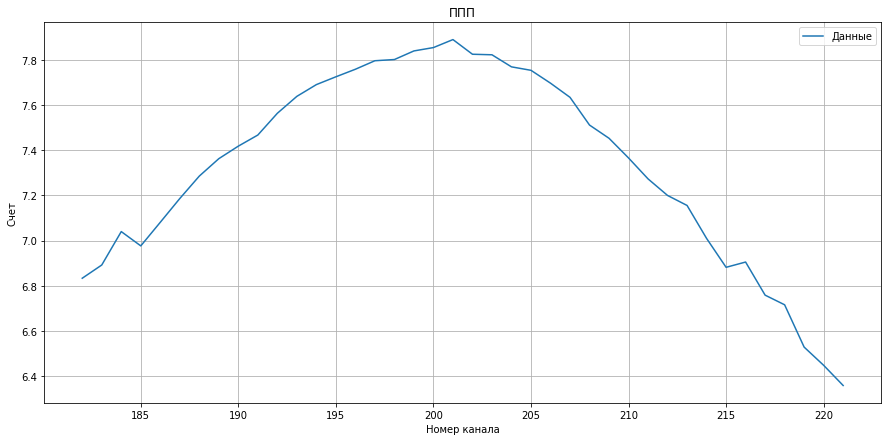

In [49]:
delta_1 = 180
delta_2 = 220

data_eu_l7 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l7, 'ППП'.decode('utf-8'), False)
plt.show()

In [50]:
popt_eu_l7, pcov_eu_l7 = curve_fit(f = gauss_function_c, xdata= data_eu_l7['Channel'],ydata=data_eu_l7['Counts'], maxfev=10000)
popt_eu_l7

array([ 2.52181202,  0.19953629,  0.01644487,  5.3206263 ])

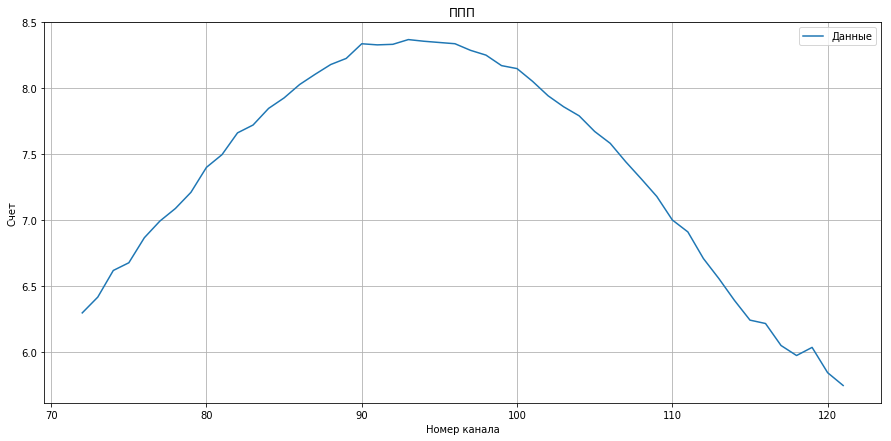

In [51]:
delta_1 = 70
delta_2 = 120

data_eu_l8 = data_eu_l.iloc[delta_1:delta_2]
draw(data_eu_l8, 'ППП'.decode('utf-8'), False)
plt.show()

In [52]:
popt_eu_l8, pcov_eu_l8 = curve_fit(f = gauss_function_c, xdata= data_eu_l8['Channel'],ydata=data_eu_l8['Counts'], maxfev=10000)
popt_eu_l8

array([ 3.65355295,  0.09362446,  0.01685116,  4.72777079])